McsPyDataTools Tutorial for CMOS-MEA files<a id='Top'></a>
=======================

This tutorial focuses on the HDF5 files generated by the MCS CMOS-MEA software (V. 2.0 and newer) and the usage of the McsPyDataTools toolbox to interact with these files.

- ### <a href='#McsPy'>The McsPy module for MCS CMOS-MEA file handling</a>
- ### <a href='#Mcs-HDF5'>Structure of the CMOS-MEA HDF5 files</a>

- ### <a href='#McsData Module'>McsData Classes and Inheritance</a>
-------------------------------------------------------------------------------------------
  
- ### <a href='#Accessing your Data with McsData'>Accessing your Data with McsData</a>
     - #### <a href='#Req'>Requirements</a>
     - #### <a href='#naming'>Naming</a>
- ### <a href='#RawData'>Raw Data Files (.cmcr)</a>
     - #### <a href='#acquisition'>Acquisition</a>
     - #### <a href='#channelStream'>ChannelStream</a>
     - #### <a href='#sensorStream'>SensorStream</a>
     - #### <a href='#eventStream'>EventStream</a>
- ### <a href='#processedData'>Processed Data Files (.cmtr)</a>
     - #### <a href='#filterTool'>Filter Tool</a>
     - #### <a href='#spikeExplorer'>Spike Explorer</a>
     - #### <a href='#networkExplorer'>Network Explorer</a>
     - #### <a href='#spikeSorter'>Spike Sorter</a>

The McsPy module for MCS CMOS-MEA file handling<a id='McsPy'></a>
---------------------------------------------------
With the ```h5py``` package, a powerful tool for accessing HDF5 files in python already exists. This toolbox builds upon h5py by subclassing its central ```h5py.Group``` and ```h5py.Dataset``` classes as ```McsGroup``` and ```McsDataset``` respectively. Thus the McsPy classes feature all attributes and methods you might be used to from working with ```h5py```, and simply extend them with MCS specific features. So if you are new to HDF5 in python you can always refer to the h5py documentation and discussions. Likewise, if you have worked with ```h5py``` previously you will find yourself in an at least familiar environment.
If you prefer to work with h5py functionalities at any point in your analysis, feel free to retrieve the h5py base object from the McsPy object attribute ```.h5py_object```

```python
    h5py_object = self.h5py_object
```

Structure of the HDF5 MCS-CMOS-MEA file system<a id='Mcs-HDF5'></a>
---------------------------------------------------

A MCS-CMOS-MEA filesystem typically consists of two seperate files. A MCS CMOS-MEA RawData (RD) HDF5 file and a MCS CMOS-MEA ProcessedData (PD) HDF5 file.
The RD file holds all raw data generated in a CMOS-MEA experiment with the CMOS-MEA-Control software, i.e. mainly different MCS data streams. The corresponding file extension is '.cmcr'.
The PD file contains all data generated in post-processing raw data with the CMOS-MEA-Tools software. Each tool in the CMOS-MEA-Tools software (Filter Tool, STA or Network Explorer, Spike Explorer, and Spike Sorter) stores its results and settings in its own subgroup. Furthermore, the CMOS-MEA-Tools make use of the HDF5 capabilities to mount HDF5 files into each other. In that sense, the PD file mounts the RD file into the "Acquisition" subgroup of its own hierarchy tree. Thus, given the link in the PD file correctly points to the RD file, this toolbox provides a set of intuitive access tools for both RD and PD via just the PD file. The corresponding file extension is '.cmtr'.

As the McsPyDataTools toolbox works with the underlying, strictly hierarchical HDF5 structure, the starting point of every data exploration with the McsPyDataTools toolbox is the ```McsData``` object. As the docstrings of the class already imply, this class was designed to hold the information of a complete CMOS-MEA HDF5 file system.

```python
    data = McsCMOSMEA.McsData('path to your data')
```

We highly recommend the supplementary use of the HDF Group's **HDFView** software to help visualize and understand the structure of HDF5 files. This makes accessing the data much easier.

<a href='#Top'>Back to index</a>

McsData Classes and Inheritance <a id='McsData Module'></a>
---------------------------------------------------------------------------------------

Generally, the McsPyDataTools toolbox creates a structure that, upon navigation through the file, reflects the CMOS-MEA HDF5 file structure, e.g. just as the CMOS-MEA HDF5 file system holds raw data in the "Acquisition" subgroup, the McsData object has an attribute ```data.Acquisition```. Therefore, you can refer to the following graphical representation of the CMOS-MEA HDF5 file hierarchy for easy navigation through the python objects.

Note: The subgroups of the root will not be accessible if they do not exist in the loaded CMOS-MEA file system.

<a id='file_structure_graphic'></a>
<img src="./Cmos_Hierarchy_short.png">

Upon initialization with the path to your data

```python
    data = McsCMOSMEA.McsData('path to your data')
```

member methods of this class will check if the provided file meets the version requirements to be further processed. This is neccessary, as not only the way how MCS programs handle the HDF5 formatted files may change, but the file format itself can undergo changes.

Afterwards all information about the data stored in the file is retrieved from the HDF5 attributes, decoded and saved in the attribute ```.attributes``` as a dictionary. The ```.attributes``` dictionary is created for every McsPy object.

```python
    data.attributes
```

An access request on one of the subgroups or datasets (i.e. Acquisition, Filter Tool, STA Explorer, Network Explorer, Spike Explorer, Spike Sorter) readies the respective data:

```python
    aquisition_data = data.Aquisition
```

This instantiates a new McsPy object holding the all data about the requested subgroup.

<a href='#Top'>Back to index</a>

## Accessing your Data with McsData<a id='Accessing your Data with McsData'></a>

Now that the general structure of a HDF5 file and the McsPy package with its McsData class is clear, we can walk through some quick and easy examples of how to access and visualize your data.


Navigation through McsPy objects implements two central concepts:
1. Groups work like dictionaries or classes.
2. Datasets work like numpy arrays.

### Naming<a id='naming'></a>

Wherever possible, McsPy names instances and attributes as found in the CMOS-MEA HDF5 file system. However, some systematic substitutions in group, dataset, and attribute naming are necessary to ensure python compatibility:


| **HDF5 MCS-CMOS-MEA** | **McsPyDataTools toolbox**     |
|-----------------------|----------------------------|
| whitespace            | _                          |
| .                     | _                          |
| ,                     | _                          |
| @                     | at                         |
| (                     | (character removed)        |
| )                     | (character removed)        |
| :                     | (character removed)        |

### Requirements <a id='Req'></a>

So let's dig in and get an impression of working with MCS CMOS-MEA data.

First some modules need to be imported:

In [1]:
# These are the imports of the McsData module
import sys, importlib, os

import McsPy
import McsPy.McsCMOSMEA as McsCMOSMEA

# matplotlib.pyplot will be used in these examples to generate the plots visualizing the data
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.widgets import Slider, AxesWidget
import matplotlib.animation as animation
from IPython.display import HTML
# These adjustments only need to be made so that the plot gets displayed inside the notebook
%matplotlib inline
# %config InlineBackend.figure_formats = {'png', 'retina'}

# numpy is numpy & pandas os pandas
import numpy as np
import pandas as pd

# bokeh adds more interactivity to the plots within notebooks. Adds toolbar at the top-right corner of the plot.
# Allows zooming, panning and saving of the plot
import bokeh.io
import bokeh.plotting

# IMPORT cv2 to write a video
from cv2 import VideoWriter, VideoWriter_fourcc

#import widgets
from ipywidgets import *
from ipywebrtc import VideoStream

# autoreload modules
%load_ext autoreload
%autoreload 2

Then, we need to define where the test data is located. This needs to be adjusted to your local setup! The McsPyDataTools toolbox includes a set of small test files in its `tests/TestData` folder. An archive with larger test files can be downloaded from the [Multi Channel DataManager](https://www.multichannelsystems.com/software/multi-channel-datamanager) page.

In [2]:
path2TestData = r'..\\McsPyDataTools\\McsPy\\tests\\TestData' # adjust this!

Sometimes running Python applications in the background can interfere with the functionalities of this notebook. To make sure that all plots are created correctly you are best advised to exit any other Python related processes.

## Raw Data Files (.cmcr)<a id='RawData'></a>

In order to access a raw data file with extension `.cmcr`, we need to initialize an instance of the McsData class from the McsData module with the path to the file:

In [3]:
path2TestDataFile1 = os.path.join(path2TestData, "V200-SensorRoi-3Aux-Dig-Stim2-DiginEvts-5kHz.cmcr")
data = McsCMOSMEA.McsData(path2TestDataFile1)

**Note**: The ```McsData``` call actually determines the type of MCS HDF5 file system which you have called, and returns an instance of an appropriate class. Do not be confused if the return is not an instance of ```McsData``` as you have maybe expected.

To check if we got access to the file we can simply print the object. This gives a rough overview of the contents of the CMOS MEA RawData, or CMOS MEA ProcessedData file. In general, all McsGroup objects provide some information about themselves and a table of all subgroups or datasets (which you can check against the file hierarchy image) upon printing. The table also provides the McsPy access name of all contents.

In [4]:
print(data)

<McsCMOSMEAData instance at 0x246d6401ef0>

This object represents the Mcs CMOS MEA file:
Filename:   V200-SensorRoi-3Aux-Dig-Stim2-DiginEvts-5kHz.cmcr

Date                 Program                     Version     
-------------------  --------------------------  ----------
10.10.2017 10:08:46  CMOS-MEA-Control            2.0.0.0     


Content:

|        Mcs Type         |        HDF5 name        |       McsPy name        |
Groups:
|       Acquisition       |       Acquisition       |       Acquisition       |
-------------------------------------------------------------------------------
Datasets:
    None



The root object holds information about the **Date** of the recording, the **Program** which was used as well as its **Version**.

Feel free to browse the ```self.attributes``` on any instance of ```McsGroup``` or ```McsDataset``` for more detailed information. And finally, you can call ```McsGroup.tree(self)``` for an 'indent-tree' of the current HDF5 Group and all its descendants. Feel free to check the output against the file hierarchy image <a href='#file_structure_graphic'>above</a>.

**Note**: As file trees may become very large very quickly, you are advised to print the instance rather than the tree once you are familiar with the MCS HDF5 file system.

In [5]:
print(data.tree())

/
    Acquisition                        
        Analog_Data                        
            ChannelData_1                      
            ChannelMeta                        
        Digital_Data                       
            ChannelData_1                      
            ChannelMeta                        
        Digital_Data_Events                
            EventData                          
            EventMeta                          
        STG_Sideband_Events                
            EventData                          
            EventMeta                          
            StimulationSites                   
        STG_Waveform                       
            ChannelData_1                      
            ChannelMeta                        
            StimulationSites                   
        Sensor_Data                        
            SensorData_1_1                     
            SensorMeta                         



<a href='#Top'>Back to index</a>

### Accessing Acquisition Data<a id='acquisition'></a>

From the table we see that we can access the RawData, which is stored in the 'Acquisition' group of the MCS HDF5 file by simply calling the acquisition attribute on our ```data``` instance. Let's go ahead and get a glimpse of the raw data streams in the file.

In [6]:
print(data.Acquisition)

-------------------------------------------------------------------------------
Parent Group: <class 'McsPyDataTools.McsPy.McsCMOSMEA.Acquisition' object at 0x246d64201d0>

-------------------------------------------------------------------------------


|         Subtype         |        HDF5 name        |       McsPy name        |
ChannelStream
|        Auxiliary        |       Analog Data       |       Analog_Data       |
|         Digital         |      Digital Data       |      Digital_Data       |
|       StgWaveform       |      STG Waveform       |      STG_Waveform       |
-------------------------------------------------------------------------------
EventStream
|       DigitalPort       |   Digital Data Events   |   Digital_Data_Events   |
|       StgSideband       |   STG Sideband Events   |   STG_Sideband_Events   |
-------------------------------------------------------------------------------
SensorStream
|       CMosSensor        |       Sensor Data       |       Sensor

#### Channel Streams<a id='channelStream'></a>
We can navigate further to start and work with some channel data.

In [7]:
print(data.Acquisition.STG_Waveform)

-------------------------------------------------------------------------------
Parent Group: <class 'McsPyDataTools.McsPy.McsCMOSMEA.McsChannelStream' object at 0x246d64205c0>
-------------------------------------------------------------------------------


|        Mcs Type         |        HDF5 name        |       McsPy name        |
Groups:
    None
-------------------------------------------------------------------------------
Datasets:
|       ChannelData       |      ChannelData 1      |      ChannelData_1      |
|       ChannelMeta       |       ChannelMeta       |       ChannelMeta       |
|          Sites          |    StimulationSites     |    StimulationSites     |



The Channel Stream 'Digital Data' object contains the two data sets ```ChannelData_1``` and ```ChannelMeta```. The objects we obtain upon access are not arrays, but subclasses of ```h5py.Dataset```. However, ```h5py.Dataset```s can be accessed, sliced and manipulated just as numpy arrays. So ```h5py.Dataset```s have a shape, a size, and a data type. For more information on working with Datasets please refer to the h5py <a href='https://readthedocs.org/projects/h5py/'>documentation</a>.

In [8]:
print('Shape:'.ljust(10)+str(data.Acquisition.STG_Waveform.ChannelData_1.shape))
print('Size:'.ljust(10)+str(data.Acquisition.STG_Waveform.ChannelData_1.size))
print('Type:'.ljust(10)+str(data.Acquisition.STG_Waveform.ChannelData_1.dtype))

Shape:    (1, 10000)
Size:     10000
Type:     int32


Now, let's go ahead and visual the signal of a channel we recorded:

Text(0.5, 1.0, 'Signal recorded by Channel 2')

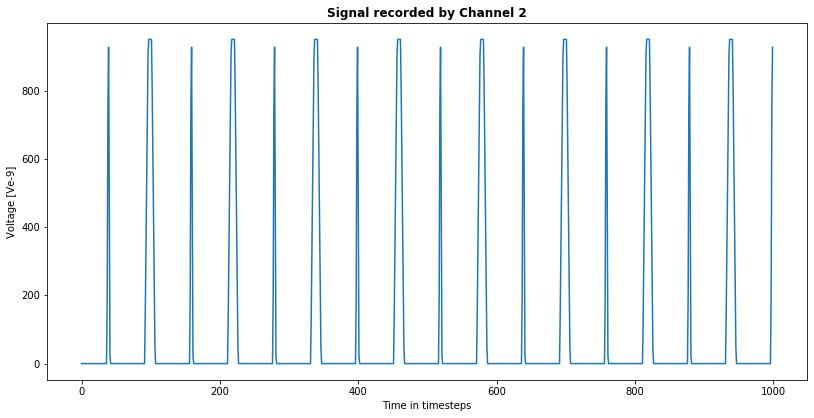

In [9]:
channeldata_1 = data.Acquisition.STG_Waveform.ChannelData_1
exponent = data.Acquisition.STG_Waveform.ChannelData_1.Meta['Exponent'][0]
channel_id = data.Acquisition.STG_Waveform.ChannelData_1.Meta['ChannelID'][0]

plt.figure(figsize=(0.681*20, 0.328*20))
plt.plot(channeldata_1[0,2000:3000])
plt.ylabel('Voltage [Ve'+str(exponent)+']')
plt.xlabel('Time in timesteps')
plt.title('Signal recorded by Channel '+str(channel_id), fontweight='bold')

#### Sensor Streams<a id='sensorStream'></a>
Alternatively we can investigate a Sensor Stream.

In [10]:
print(data.Acquisition.Sensor_Data)

-------------------------------------------------------------------------------
Parent Group: <class 'McsPyDataTools.McsPy.McsCMOSMEA.McsSensorStream' object at 0x246d6507400>
-------------------------------------------------------------------------------


|        Mcs Type         |        HDF5 name        |       McsPy name        |
Groups:
    None
-------------------------------------------------------------------------------
Datasets:
|       SensorData        |     SensorData 1 1      |     SensorData_1_1      |
|       SensorMeta        |       SensorMeta        |       SensorMeta        |



To visualize the sensor data as greyscale images, we can create an animation in matplotlib and play it as a HTML video. You'll need to have **FFmpeg** available for this to work.

In [ ]:
images = data.Acquisition.Sensor_Data.SensorData_1_1

fig = plt.figure()

im = plt.imshow(images[0], animated=True, cmap='gray')
plt.title('Sensor Data 1 1')
plt.box(False)

def updatefig(i):
    global images
    im.set_array(images[i])
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)

plt.close(ani._fig)

# Call function to display the animation
HTML(ani.to_html5_video())

We can also take the sensor data and create a simple slider to go through the blocks of sensor data in time:

<IPython.core.display.Javascript object>


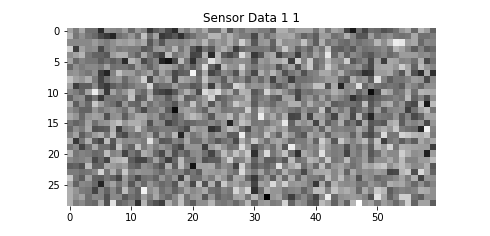

interactive(children=(IntSlider(value=0, description='Frame', max=9999), Output()), _dom_classes=('widget-inte…

In [13]:
%matplotlib notebook

images = data.Acquisition.Sensor_Data.SensorData_1_1
num_of_images = images.shape[0]-1

fig = plt.figure(figsize=(0.681*10, 0.328*10))
ax = fig.add_subplot(1,1,1)
plt.title('Sensor Data 1 1')
plt.box(False)
fig.show()
#print(images.shape)
def updateFrame(Frame):
    ax.imshow(images[Frame,::], cmap="gray")
              
_ = interact(updateFrame, Frame=widgets.IntSlider(min=0,max=num_of_images,step=1,value=0))

<a href='#Top'>Back to index</a>

#### EventStream<a id='eventStream'></a>

EventStreams can be a wide array of events predefined by the user and stored in this stream. From the beginning/end or the duration of a treatment to periodically recurring stimuli this can be everything.

<a href='#Top'>Back to index</a>

In [14]:
print(data.Acquisition.STG_Sideband_Events)

-------------------------------------------------------------------------------
Parent Group: <class 'McsPyDataTools.McsPy.McsCMOSMEA.McsEventStream' object at 0x246d9737ef0>
-------------------------------------------------------------------------------


|        Mcs Type         |        HDF5 name        |       McsPy name        |
Groups:
    None
-------------------------------------------------------------------------------
Datasets:
|        EventData        |        EventData        |        EventData        |
|        EventMeta        |        EventMeta        |        EventMeta        |
|          Sites          |    StimulationSites     |    StimulationSites     |



We prepare the data:

In [16]:
# GET pandas DataFrame FROM MCSHDF5 FORMAT
eventData = data.Acquisition.STG_Sideband_Events.EventData.to_pdDataFrame().iloc[:50,:]
eventData = eventData.sort_values(by='EventID')

# EXTRACT EVENT POSITION IN TIME
eventPosition = eventData.pivot(columns='EventID', values='TimeStamp')
eventPosition.fillna(method='ffill', axis='index', inplace=True)
eventPosition.fillna(method='bfill', axis='index', inplace=True)

# EXTRACT EVENT DURATION
eventDuration = eventData.pivot(columns='EventID', values='Duration')
eventDuration.fillna(method='ffill', axis='index', inplace=True)
eventDuration.fillna(method='bfill', axis='index', inplace=True)
eventDuration[eventDuration == 0] += 0.2 # add minimum event duration

# EXTRACT EVENT DESCRIPTION
eventMeta = data.Acquisition.STG_Sideband_Events.EventMeta.to_pdDataFrame().iloc[:50,:]
eventMeta = eventMeta.sort_values(by='EventID')
eventLabels = eventMeta.loc[eventMeta['EventID'].isin(eventData.EventID.unique())]['Label'].tolist()

And visualize it

<IPython.core.display.Javascript object>


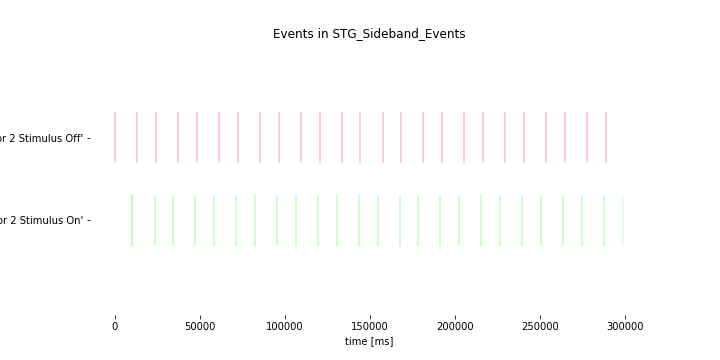

In [17]:
# VISUALIZE EVENTS
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

colors = [[0, 1, 0], [1, 0, 0]]

ax.eventplot(eventPosition.values.transpose(), 
                   linewidth=eventDuration.values.transpose(), 
                   linelength = 0.62,
                   colors=colors)

ax.set_title('Events in STG_Sideband_Events')
ax.set_xlabel('time [ms]')
ax.set_ylabel('Event')
ax.set_yticks(range(len(eventLabels)))
ax.set_yticklabels(eventLabels)
plt.box(False)

## Processed Data Files (.cmtr)<a id='processedData'></a>

Processed data files with the file extension `.cmtr` are created by the CMOS-MEA-Tools software and contain the analysis results from different data sources. To access them, we need to create an instance of McsData in the same way as for the Raw Data files:

In [3]:
path2TestDataFile2 = os.path.join(path2TestData, "CMOS_MEA_Results.cmtr")
processed = McsCMOSMEA.McsData(path2TestDataFile2)

The easiest way to see the file contents is to print the object

In [19]:
print(processed)

<McsCMOSMEAData instance at 0x246d97f6ba8>

This object represents the Mcs CMOS MEA file:
Filename:   result_file_with_network_explorer.cmtr

Date                 Program                     Version     
-------------------  --------------------------  ----------
16.12.2019 11:34:19  CMOS-MEA-Tools              2.4.0.0     


Content:

|        Mcs Type         |        HDF5 name        |       McsPy name        |
Groups:
|       Acquisition       |       Acquisition       |       Acquisition       |
|       SummaryTool       |    Activity Summary     |    Activity_Summary     |
|       FilterTool        |       Filter Tool       |       Filter_Tool       |
|   NetworkExplorerTool   |    Network Explorer     |    Network_Explorer     |
|    SpikeExplorerTool    |     Spike Explorer      |     Spike_Explorer      |
|       SpikeSorter       |      Spike Sorter       |      Spike_Sorter       |
-------------------------------------------------------------------------------
Datasets:
    

The file contains 5 different data sources: `Acquisition`, `Filter Tool`, `STA Explorer`, `Spike Explorer` and `Spike Sorter`. Of these, `Acquisition` is a special case because it is actually a link to the `Acquisition` group in the Raw Data file `2017.12.14-18.38.15-GFP8ms_470nm_100pc_10rep_nofilter.cmcr` that served as input to the analysis in CMOS-MEA-Tools. Still, you can access the contents of this group as usual:

In [20]:
print(processed.Acquisition)
print(processed.Acquisition.SensorStreams)
print(processed.Acquisition.SensorStreams[0].SensorData[0].shape)

-------------------------------------------------------------------------------
Parent Group: <class 'McsPyDataTools.McsPy.McsCMOSMEA.Acquisition' object at 0x246d9971240>

-------------------------------------------------------------------------------


|         Subtype         |        HDF5 name        |       McsPy name        |
ChannelStream
|         Digital         |      Digital Data       |      Digital_Data       |
-------------------------------------------------------------------------------
EventStream
|       DigitalPort       |EventTool @ Digital Data |EventTool_at_Digital_Data|
-------------------------------------------------------------------------------
SensorStream
|       CMosSensor        |       Sensor Data       |       Sensor_Data       |
-------------------------------------------------------------------------------

|              Subtype              |            McsPy name             |             HDF5 name             |
SensorStream:
|            CMosSens

For more details about the interaction with the `Acquisition` group, please refer to the <a href='#RawData'>Raw Data</a> section above. Because it is a link to a different file, it is necessary that a file with the correct name is found in the same folder as the ProcessedData file.

The other data sources correspond to different tools in the CMOS-MEA-Tools software. Please note that data sources are only present if they had been activated for the analysis in CMOS-MEA-Tools, so it is possible that other `.cmtr` files contain a different set of data sources.

<a href='#Top'>Back to index</a>

### Filter Tool<a id='filterTool'></a>

The `Filter_Tool` contains the settings for the filter pipeline applied to the raw data in CMOS-MEA-Tools:

In [21]:
print(processed.Filter_Tool)
print("Filter Order: " + str(processed.Filter_Tool.Pipe['1 High-Pass']['Order'][0]))
print("Cutoff Frequency: " + str(processed.Filter_Tool.Pipe['1 High-Pass']['CutOffFrequency'][0]) + " Hz")

-------------------------------------------------------------------------------
Parent Group: <class 'McsPyDataTools.McsPy.McsCMOSMEA.FilterTool' object at 0x246d99718d0>
-------------------------------------------------------------------------------


|        Mcs Type         |        HDF5 name        |       McsPy name        |
Groups:
|        PipeModel        |          Pipe           |          Pipe           |
-------------------------------------------------------------------------------
Datasets:
|   SettingsFilterTool    |   SettingsFilterTool    |   SettingsFilterTool    |

Filter Order: 2
Cutoff Frequency: 300.0 Hz


<a href='#Top'>Back to index</a>

### Spike Explorer<a id='spikeExplorer'></a>

The `Spike_Explorer` holds settings for the channel-wise spike detector in CMOS-MEA-Tools, as well as its detected spikes:

In [22]:
print(processed.Spike_Explorer)

-------------------------------------------------------------------------------
Parent Group: <class 'McsPyDataTools.McsPy.McsCMOSMEA.SpikeExplorer' object at 0x246d97f6f60>
-------------------------------------------------------------------------------


|        Mcs Type         |        HDF5 name        |       McsPy name        |
Groups:
    None
-------------------------------------------------------------------------------
Datasets:
|   SettingsMapCreator    |   SettingsMapCreator    |   SettingsMapCreator    |
|  SettingsSpikeDetector  |  SettingsSpikeDetector  |  SettingsSpikeDetector  |
|  SettingsSpikeExplorer  |  SettingsSpikeExplorer  |  SettingsSpikeExplorer  |
|SettingsSpikePeakActivity|SettingsSpikePeakActivity|SettingsSpikePeakActivity|
|        SpikeData        |        SpikeData        |        SpikeData        |
|        SpikeMeta        |        SpikeMeta        |        SpikeMeta        |



The detection threshold and other details for the spike detector can be found in the `SettingsSpikeDetector` data set:

In [23]:
processed.Spike_Explorer.SettingsSpikeDetector['Threshold'][0]

5.0

The detected spikes are contained in the `SpikeData` dataset. It stores for each spike the `SensorID` of the detection location, the `TimeStamp` as the detection time in µs and an optional signal cutout around the spike timestamp:

In [24]:
print(processed.Spike_Explorer.SpikeData)

Compound McsDataset SpikeData

location in hdf5 file:   /Spike Explorer/SpikeData
shape:                   /Spike Explorer/SpikeData(18486,)
dtype:                   /Spike Explorer/SpikeData[('SensorID', '<i4'), ('TimeStamp', '<i8'), ('1', '<f8'), ('2', '<f8'), ('3', '<f8'), ('4', '<f8'), ('5', '<f8'), ('6', '<f8'), ('7', '<f8'), ('8', '<f8'), ('9', '<f8'), ('10', '<f8'), ('11', '<f8'), ('12', '<f8'), ('13', '<f8'), ('14', '<f8'), ('15', '<f8'), ('16', '<f8'), ('17', '<f8'), ('18', '<f8'), ('19', '<f8'), ('20', '<f8'), ('21', '<f8'), ('22', '<f8'), ('23', '<f8'), ('24', '<f8'), ('25', '<f8'), ('26', '<f8'), ('27', '<f8'), ('28', '<f8'), ('29', '<f8'), ('30', '<f8'), ('31', '<f8'), ('32', '<f8'), ('33', '<f8'), ('34', '<f8'), ('35', '<f8'), ('36', '<f8'), ('37', '<f8'), ('38', '<f8'), ('39', '<f8'), ('40', '<f8'), ('41', '<f8'), ('42', '<f8'), ('43', '<f8'), ('44', '<f8'), ('45', '<f8'), ('46', '<f8'), ('47', '<f8'), ('48', '<f8'), ('49', '<f8'), ('50', '<f8'), ('51', '<f8'), ('52', '<

This allows us to do different visualizations of the spike data:

#### Raster Plot

We can generate a raster plot for one or more sensors:

<IPython.core.display.Javascript object>


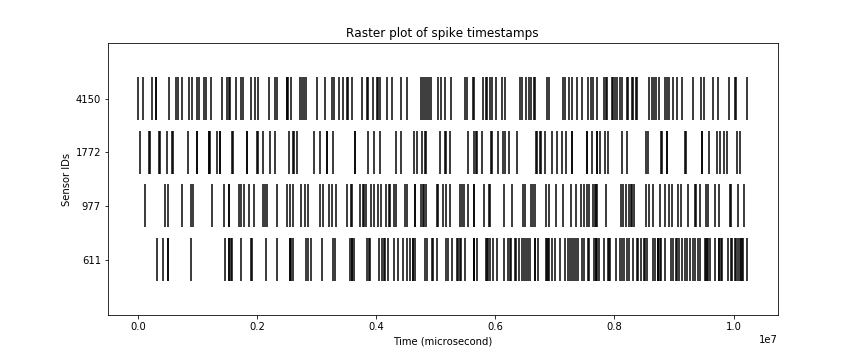

In [26]:
sensors_to_plot = [611, 977, 1772, 4150]
timestamps = processed.Spike_Explorer.get_spike_timestamps_at_sensors(sensors_to_plot)
plt.figure(figsize=(12,5))
_ = plt.eventplot(timestamps.values(), linelengths=0.8, colors='k')
_ = plt.xlabel('Time (microsecond)')
_ = plt.ylabel('Sensor IDs')
_ = plt.yticks(labels=[str(s) for s in timestamps.keys()], ticks=range(len(sensors_to_plot)))
_ = plt.title('Raster plot of spike timestamps')

#### Spike Counts

Another option is to plot the spike counts for all sensors... the lighter, the more spikes were detected on the sensor:

<IPython.core.display.Javascript object>


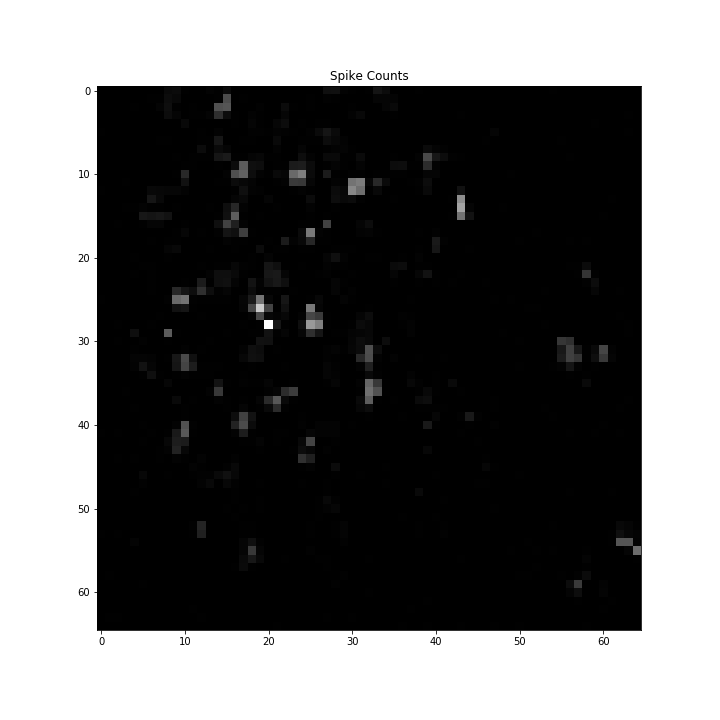

In [27]:
ids_with_spikes, spike_counts = np.unique(processed.Spike_Explorer.SpikeData['SensorID'], return_counts=True)
sensor_counts = np.zeros((65, 65))
for i in range(len(ids_with_spikes)):
    sensor = ids_with_spikes[i]
    count = spike_counts[i]
    row,col = (sensor-1) % 65, (sensor-1) // 65
    sensor_counts[row,col] = count

plt.figure(figsize=(10,10))
_ = plt.imshow(sensor_counts)
plt.set_cmap("gray")
plt.title('Spike Counts')
plt.show()

#### Spike Cutouts

Finally, we can also check out an overlay of the spike cutouts of a sensor:

<IPython.core.display.Javascript object>


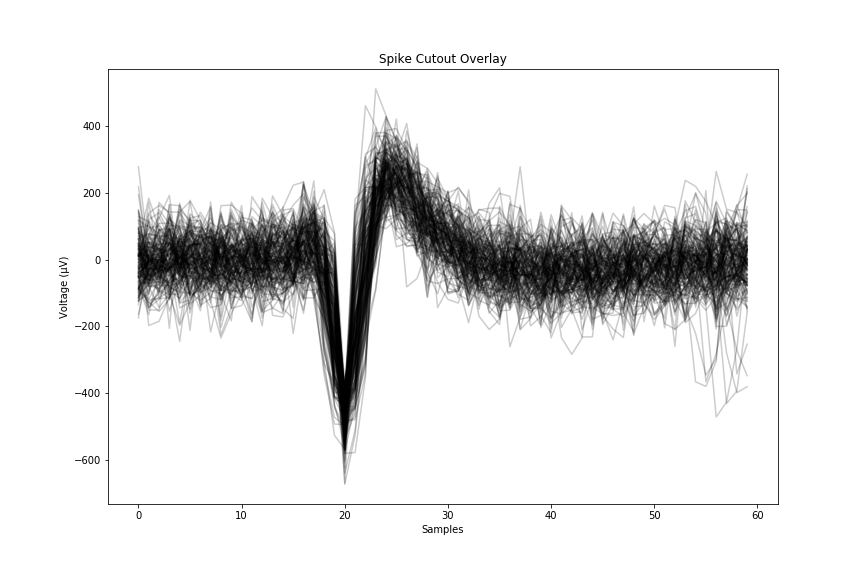

In [28]:
cutouts = processed.Spike_Explorer.get_spike_cutouts_at_sensor(611)
plt.figure(figsize=(12,8))
_ = plt.plot(np.transpose(cutouts*1e-3), color='k', alpha=0.2)
plt.xlabel('Samples')
plt.ylabel('Voltage (µV)')
plt.title('Spike Cutout Overlay')
plt.show()

<a href='#Top'>Back to index</a>

### Network Explorer / STA Explorer<a id='networkExplorer'></a>

The `Network_Explorer` (this tool was called the `STA_Explorer` in earlier versions) contains datasets with spike-triggered averages. They represent the averaged activation on all sensors on the chip relative to the spiking activity of a single sensor/neuron and can be very useful to detect axonal propagation of spiking activity across the chip. 

The results of either the `Spike_Explorer` or the `Spike_Sorter` can serve as input to the `Network_Explorer`.

The STA data is a block of data with dimensions `samples x sensors_Y x sensors_X` and can be visualized as a stack of 2-dimensional frames of a movie. 

<IPython.core.display.Javascript object>


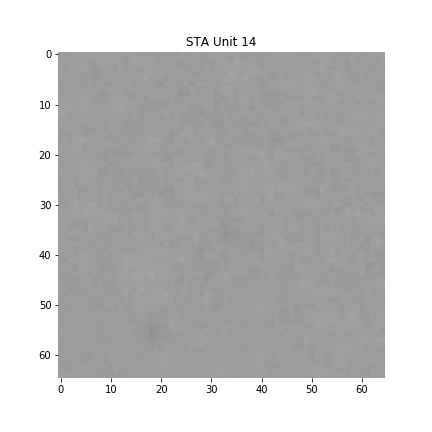

interactive(children=(IntSlider(value=0, description='Frame', max=79), Output()), _dom_classes=('widget-intera…

In [29]:
%matplotlib notebook

sta = processed.Network_Explorer.get_sta_entity_by_sourceID(14)

images = sta.data
num_of_images = images.shape[0]-1

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
plt.title('STA Unit 14')
plt.box(False)
fig.show()

def updateFrame(Frame):
    ax.imshow(np.transpose(images[Frame,::]), cmap="gray", vmin=np.amin(images), vmax=np.amax(images))
              
_ = interact(updateFrame, Frame=widgets.IntSlider(min=0,max=num_of_images,step=1,value=0))

`Network_Explorer` data sources in files created by CMOS-MEA-Tools Version 2.4 and newer may contain axon tracking results in the `processed.Network_Explorer.NeuralNetwork` property. The extracted axon paths for individual units can be visualized like this:

<IPython.core.display.Javascript object>


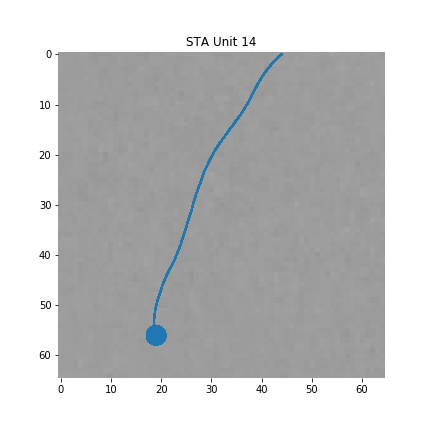

interactive(children=(IntSlider(value=0, description='Frame', max=79), Output()), _dom_classes=('widget-intera…

In [30]:
%matplotlib notebook

import matplotlib.lines as mlines

sta = processed.Network_Explorer.get_sta_entity_by_sourceID(14)

images = sta.data
num_of_images = images.shape[0]-1

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
plt.title('STA Unit 14')
plt.box(False)
fig.show()

def updateFrame(Frame):
    last_sensor = (sta.sensor_coordinates[1], sta.sensor_coordinates[0])
    ax.imshow(np.transpose(images[Frame,::]), cmap="gray", vmin=np.amin(images), vmax=np.amax(images))
    ax.add_artist(plt.Circle(last_sensor, 2))
    for step in sta.axon:
        ax.add_line(mlines.Line2D([last_sensor[0]-1, step[0]-1], [last_sensor[1]-1, step[1]-1]))
        last_sensor = step
              
_ = interact(updateFrame, Frame=widgets.IntSlider(min=0,max=num_of_images,step=1,value=0))

<a href='#Top'>Back to index</a>

### Spike Sorter<a id='spikeSorter'></a>

The `Spike_Sorter` data source contains neuronal units as the result of the CMOS-MEA-Tools spike sorting. Each unit is represented by its own group in the data source, while quality measures and other meta data for all units are contained in the `Spike_Sorter.Units` data set. 

In [31]:
print(processed.Spike_Sorter)

-------------------------------------------------------------------------------
Parent Group: <class 'McsPyDataTools.McsPy.McsCMOSMEA.SpikeSorter' object at 0x246dcd71080>
-------------------------------------------------------------------------------


|        Mcs Type         |        HDF5 name        |       McsPy name        |
Groups:
|       SingleUnit        |         Unit 1          |         Unit_1          |
|       SingleUnit        |         Unit 10         |         Unit_10         |
|       SingleUnit        |         Unit 11         |         Unit_11         |
|       SingleUnit        |         Unit 12         |         Unit_12         |
|       SingleUnit        |         Unit 13         |         Unit_13         |
|       SingleUnit        |         Unit 14         |         Unit_14         |
|       SingleUnit        |         Unit 15         |         Unit_15         |
|       SingleUnit        |         Unit 16         |         Unit_16         |
|       SingleUnit

For ease of use, some convenience functions are available to access units and quality measures:

In [38]:
processed.Spike_Sorter.get_units_by_id() # lists all units, ordered by unit id
processed.Spike_Sorter.get_units_by_measure('Kurtosis') # lists all units ordered by the given quality measure
processed.Spike_Sorter.get_unit_measures() # lists all quality measures

['SDScore',
 'AmplitudeSD',
 'RSTD',
 'Separability',
 'IsoINN',
 'IsoIBg',
 'NoiseStd',
 'SNR',
 'Skewness',
 'Kurtosis',
 'IcaConverged',
 'IcaIterations']

Each unit contains 5 data sets:
- `Peaks`: Contains all peaks detected in the `Source` signal, including peaks below the spike detection threshold. This is necessary for the automatic spike threshold estimation in the CMOS-MEA-Tools Spike Sorter. For peaks larger than the spike detection threshold, their `'IncludePeak'` flag is set to `1`.
- `RoiSTAs`: Contains the spike triggered averages for the subset of sensors comprising the "ROI" of the unit. The spike-triggered average is computed by taking the timestamp of all `Peaks` where `'IncludePeak'` is set, extracting a signal cutout for all sensors in the unit ROI around each timestamp and averaging these cutouts over all timestamps. The STA dimensions are `channels x samples`.
- `Source`: Contains the dimensionless source signal for the unit in ICA space.
- `Unit_Info`: Contains the meta data for the unit, including its quality measures
- `Unmixing`: Contains a `channels x embedding` matrix that represents the projection from raw channel data to ICA space. Creating `embedding` many sample-shifted copies of the raw data for all channels in the unit ROI and then multiplying this with the `Unmixing` matrix will create the `Source` signal.

In [4]:
unit = processed.Spike_Sorter.get_unit(14) # get unit by unit id
unit.get_measure('Separability')

7.64561711669349

<a href='#Top'>Back to index</a>

#### Source

The source signal has no associated units but can be drawn like any other sampled signal.

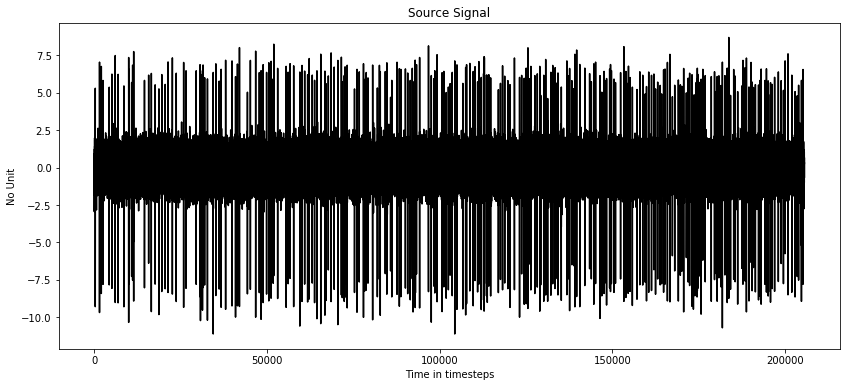

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(unit.Source, 'k')
plt.ylabel('No Unit')
plt.xlabel('Time in timesteps')
_ = plt.title('Source Signal')

<a href='#Top'>Back to index</a>

#### Peaks

We can easily visualize the detected peaks in the source signal as a cutout overlay

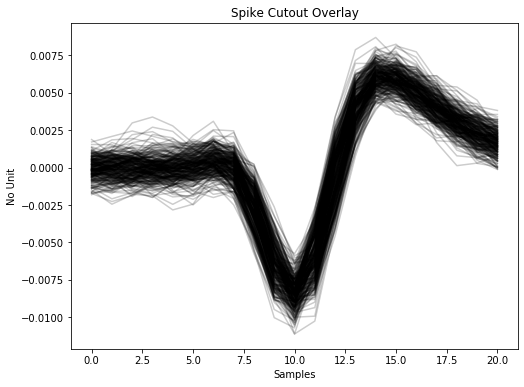

In [7]:
cutouts = unit.get_peaks_cutouts()
plt.figure(figsize=(8,6))
_ = plt.plot(np.transpose(cutouts*1e-3), color='k', alpha=0.2)
plt.xlabel('Samples')
plt.ylabel('No Unit')
plt.title('Spike Cutout Overlay')
plt.show()

<a href='#Top'>Back to index</a>